In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [3]:
#get the data
df = pd.read_pickle("accidents.pkl")

#pick only personal vehicles
df = df.query("p44 == 3 or p44 == 4")

#categorize p44
df["p44"] = df["p44"].astype('category')

#categorize p12
accidentCauseBins = [100,200,300,400,500,600,700]
# accidentCauseLabels = [
#     "nezaviněná řidičem",
#     "nepřiměřená rychlost jízdy",
#     "nesprávné předjíždění",
#     "nedání přednosti v jízdě",
#     "nesprávný způsob jízdy",
#     "technická závada vozidla"
# ]
accidentCauseLabels = [
    100,
    200,
    300,
    400,
    500,
    600
]
df["p12c"] = pd.cut(df["p12"], bins=accidentCauseBins, labels=accidentCauseLabels, include_lowest=True, right=False, ordered=False)

df = df.rename(columns={'p44':'trailer'})
df['trailer'] = df['trailer'].cat.rename_categories({3:False, 4:True})

#get relevant data (alcohol use and accident seriousness)
df["alcohol_use"] = df.apply(lambda row : row['p11'] >= 7, axis=1)
df["accident_seriousness"] = df.apply(lambda row : (row['p13a']+row['p13b']) > 0, axis=1)

Plot accident seriousness for vehicles with and without trailer

In [114]:
#normalize values (there are so many more accidents without trailer)
df_group = df.groupby(['accident_seriousness','p12c','trailer'])['p1'].agg('count').unstack(level=0)

print(df_group)

#split by accident seriousness
df_serious = df_group[True].unstack()
df_light = df_group[False].unstack()

df_serious[False] = df_serious[False].map(lambda x : x/df_serious[False].sum())
df_serious[True] = df_serious[True].map(lambda x : x/df_serious[True].sum())
df_light[False] = df_light[False].map(lambda x : x/df_light[False].sum())
df_light[True] = df_light[True].map(lambda x : x/df_light[True].sum())

print(df_serious)
print(df_light)

accident_seriousness   False  True 
p12c trailer                       
100  False             61232    398
     True                292      4
200  False             47747   1967
     True                565     19
300  False              4323    256
     True                 75      7
400  False             50645   2367
     True                376     31
500  False            132836   2238
     True               1247     24
600  False               414      4
     True                118      1
trailer     False      True
p12c                       
100      0.055048  0.046512
200      0.272061  0.220930
300      0.035408  0.081395
400      0.327386  0.360465
500      0.309544  0.279070
600      0.000553  0.011628
trailer     False      True
p12c                       
100      0.206032  0.109241
200      0.160658  0.211373
300      0.014546  0.028058
400      0.170409  0.140666
500      0.446963  0.466517
600      0.001393  0.044145


In [127]:
df_group2 = df.groupby(['accident_seriousness','p12c','trailer'])['p1'].agg('count').unstack(level=2)

#split by trailer use
df_trailer = df_group2[True].unstack(level=0)
df_no_trailer = df_group2[False].unstack(level=0)

#compute proportions
df_trailer[False] = df_trailer[False].map(lambda x : x/df_trailer[False].sum())
df_trailer[True] = df_trailer[True].map(lambda x : x/df_trailer[True].sum())
df_no_trailer[False] = df_no_trailer[False].map(lambda x : x/df_no_trailer[False].sum())
df_no_trailer[True] = df_no_trailer[True].map(lambda x : x/df_no_trailer[True].sum())

print(df_trailer)

trailer                     False  True
accident_seriousness p12c              
False                100    61232   292
                     200    47747   565
                     300     4323    75
                     400    50645   376
                     500   132836  1247
                     600      414   118
True                 100      398     4
                     200     1967    19
                     300      256     7
                     400     2367    31
                     500     2238    24
                     600        4     1
accident_seriousness     False     True 
p12c                                    
100                   0.109241  0.046512
200                   0.211373  0.220930
300                   0.028058  0.081395
400                   0.140666  0.360465
500                   0.466517  0.279070
600                   0.044145  0.011628


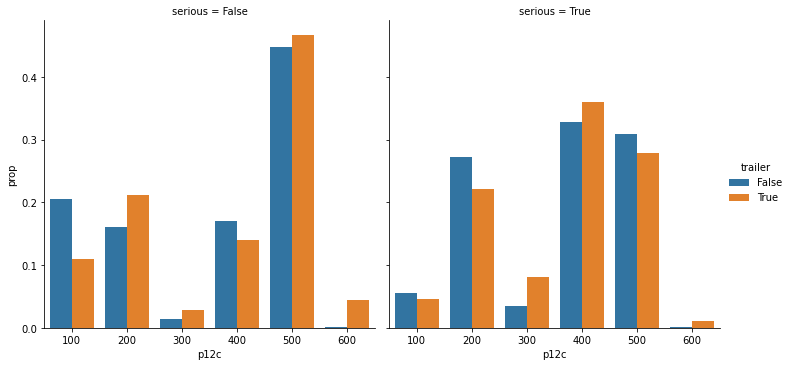

In [110]:
df_serious_unstacked = df_serious.unstack().reset_index().rename(columns={0:'prop'})
df_light_unstacked = df_light.unstack().reset_index().rename(columns={0:'prop'})
df_serious_unstacked['serious'] = True
df_light_unstacked['serious'] = False
df_c = pd.concat([df_serious_unstacked, df_light_unstacked])
sns.catplot(x='p12c', y='prop', hue='trailer', col='serious', data=df_c, kind='bar')
# fig, ax = plt.subplots(ncols=2)
# sns.catplot(x='p12c', y='prop', hue='trailer', data=df_light, kind='bar', ax=ax[0])
# sns.catplot(x='p12c', y='prop', hue='trailer', data=df_serious, kind='bar', ax=ax[1])

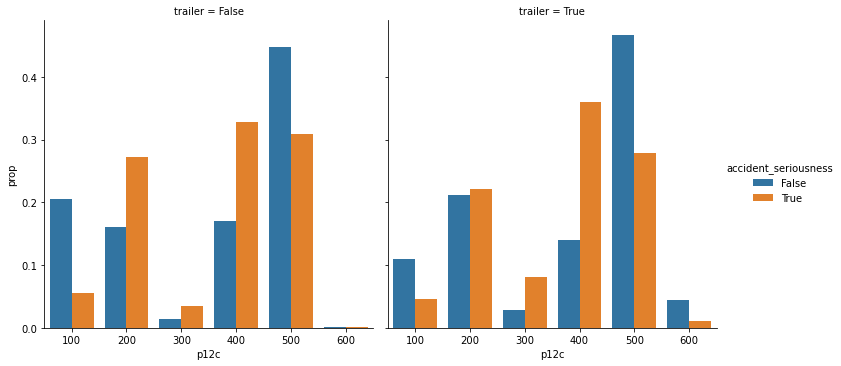

In [129]:
df_trailer_unstacked = df_trailer.unstack().reset_index().rename(columns={0:'prop'})
df_no_trailer_unstacked = df_no_trailer.unstack().reset_index().rename(columns={0:'prop'})
df_trailer_unstacked['trailer'] = True
df_no_trailer_unstacked['trailer'] = False
df_c = pd.concat([df_trailer_unstacked, df_no_trailer_unstacked])
sns.catplot(x='p12c', y='prop', hue='accident_seriousness', col='trailer', data=df_c, kind='bar')

Test for dependence between trailer use and accident seriousness

In [113]:
alpha = 0.05

cross = pd.crosstab(index=df['trailer'], columns=df['accident_seriousness'])
print(cross)

stat, p, dof, expected = chi2_contingency(cross)
print(f"{p=}\n{stat=}")

if p <= alpha:
    print('Dependent')
else:
    print('Independent')

accident_seriousness   False  True 
trailer                            
False                 297197   7230
True                    2673     86
p=0.013054208299270505
stat=6.161748797182163
Dependent


Make some observations about accident causes

In [187]:
print(df_trailer.unstack())
# print(f"Seriouss Trailer accidents caused by passing: {df_c.query('accident_seriousness and trailer and p12c==300')['prop'].values[0]}")
print(df_trailer[True].loc[300])

accident_seriousness  p12c
False                 100     0.109241
                      200     0.211373
                      300     0.028058
                      400     0.140666
                      500     0.466517
                      600     0.044145
True                  100     0.046512
                      200     0.220930
                      300     0.081395
                      400     0.360465
                      500     0.279070
                      600     0.011628
dtype: float64


IndexError: index 300 is out of bounds for axis 0 with size 6